# Find compact processes

**Goal**: find biological processes thata are compact in embs space, thus will be easy to classify later.

In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

import sys
import os
os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs



from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy.spatial.distance import pdist, squareform

import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import scanpy as sc


big_palette = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
    "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#FFFF00",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
]

print(torch.__version__)

Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
2.5.0+cu121


In [2]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls, stacked_linearized_all
    "PRETRAIN_ESM_CHECKPOINT_NAME": 
        #"facebook/esm2_t48_15B_UR50D", 
        "facebook/esm2_t36_3B_UR50D",
        # #"facebook/esm2_t33_650M_UR50D", 
        # #"facebook/esm2_t12_35M_UR50D", 
        # #"facebook/esm2_t6_8M_UR50D", 

    "UNIPROT_PATH": "/home/gdallagl/myworkdir/ESMSec/data/UniProt/human_proteome.tsv",
    "UNIPROT_CELLULAR_LOCATION_FORMATTED_PATH": "/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprotkb_reviewed_cellular_locations_formatted.csv"
}

# This 2 files are create by 00_make... script
config["PRECOMPUTED_EMBS_PATH"] = os.path.join(
    f"/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs",
    f"entire_reviewed_uniprot_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
config["PRECOMPUTED_EMBS_PATH_PROTEIN_NAMES"] = config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json')
config["PRECOMPUTED_EMBS_PATH_ADATA"] = config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '.h5ad')


# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Uniprot Protein --> Gene mapping

In [6]:
data = pd.read_csv(config["UNIPROT_PATH"], sep="\t")

# Remae
data = data[["Entry", "Sequence", "Gene Names"]].rename(columns={"Entry": "protein", "Sequence": "sequence", "Gene Names": "gene"})

display(data)

# Create prot__<gene mapping
data["gene_list"] = data.gene.str.split(" ")
gene_protein_map = data[["gene_list", "protein"]].explode("gene_list")

# Create the dictionary: gene symbol -> protein ID
gene_to_protein = dict(zip(gene_protein_map.gene_list, gene_protein_map.protein))

,protein,sequence,gene
0,A0A087WZT3,MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS,BOLA2-SMG1P6
1,A0A087X1C5,MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...,CYP2D7
2,A0A087X296,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,PTGS1
3,A0A0A0MQV1,MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...,HSD11B1
4,A0A0A0MRG2,MFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQ...,APP
...,...,...,...
83582,X6RLT1,XEGMAGAVPGAIMDEDYYGSAAEWGDEADGGQQEDDSGEGEDDAEV...,NELFCD
83583,X6RLU5,XELVREVLFDAVVTAPMEAYWTALALNMSEESEHVVDMAFLGTRAG...,CACNA2D4
83584,X6RLV5,MSGYSSDRDRGRDRGFGAPRFGGSRAGPLSGKKFGNPGEKLVKKKW...,DDX5
83585,X6RLY7,MKLEFLQRKFWAATRQCSTVDGPCTQSCEDSDLDCFVIDNNGFILI...,CACNA2D4


# Load Protein anndata

In [10]:
adata = sc.read_h5ad(config["PRECOMPUTED_EMBS_PATH_ADATA"])
adata

AnnData object with n_obs × n_vars = 20405 × 2560
    uns: 'X_umap_PCA', 'X_umap_all', 'neighbors_PCA', 'neighbors_all', 'pca'
    obsm: 'X_pca', 'X_umap_PCA', 'X_umap_all'
    varm: 'PCs'
    obsp: 'neighbors_PCA_connectivities', 'neighbors_PCA_distances', 'neighbors_all_connectivities', 'neighbors_all_distances'

# Liaden Cluster

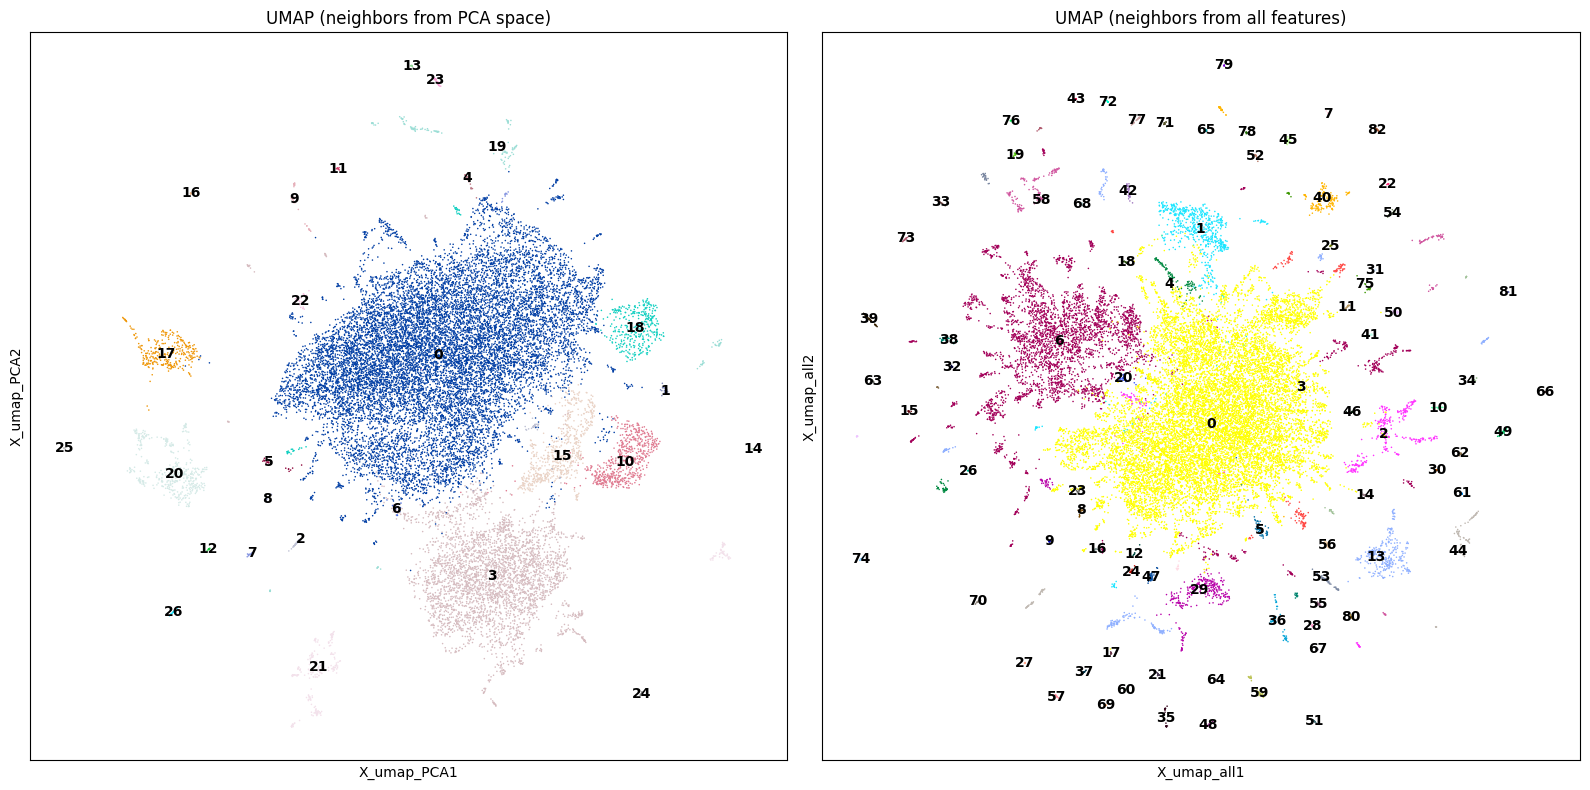

In [ ]:
sc.tl.leiden(adata, resolution=0.1, neighbors_key="neighbors_all", key_added="leiden_all", flavor="igraph", n_iterations=2)
sc.tl.leiden(adata, resolution=0.1, neighbors_key="neighbors_pca", key_added="leiden_pca", flavor="igraph", n_iterations=2)


fig, axes = my_embs.plot_embeddings(
    adata,
    basis=["X_umap_pca", "X_umap_all"],
    color=["leiden_pca", "leiden_all"],
    title=["UMAP (neighbors from pca space)", "UMAP (neighbors from all features)"],
    size=[5],
    #palette=[None, "tab20", "viridis"],
    ncols=2,  # 2 columns, 2 rows
    figsize=(16, 8), 
    legend_loc=['on data']
)
plt.show()


KeyError: "Could not find 'X_umap_pca' or 'X_X_umap_pca' in .obsm"

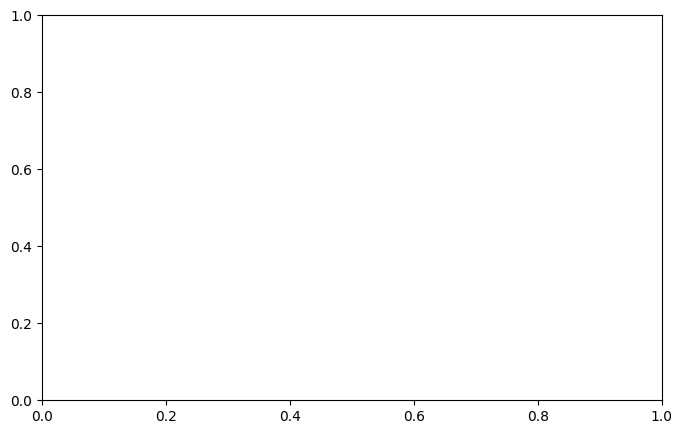

In [ ]:
# Investiagte single cluster
CLUSTER = str(3)

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=["X_umap_pca"],
    color=["leiden_pca"],
    #title=["Secreted Status"],
    size=[5],
    palette=[["#0000A6"]],
    ncols=1,  # 2 columns, 2 rows
    figsize=(8, 5), 
    groups=[CLUSTER],
)
plt.show()

uniprot_ids = adata.obs[adata.obs["leiden_pca"] == CLUSTER].index

print(f"{'UniProt ID':<12} {'Gene':<12} {'Function'}")
print("="*100)
for uid in uniprot_ids[:5]:
    gene, func = mf.get_uniprot_info(uid)
    print(f"{uid:<12} {gene:<12} {func}")

# Search by Secreted

Check if secreted proteins cluster in specific region.

In [9]:
df_secreted = pd.read_csv(config["UNIPROT_CELLULAR_LOCATION_FORMATTED_PATH"])

# make col set and not str
df_secreted['location'] = df_secreted['location'].apply(ast.literal_eval)
df_secreted['n_location'] = df_secreted['location'].apply(len)


# Take all proteins that have sectred
df_secreted = df_secreted[(df_secreted["location"].apply(lambda x: len(set(["Secreted"]).intersection(x)) != 0 ))]

# Takje only the one that are ONLY secreted
#df_secreted = df_secreted[df_secreted.n_location == 1]

# sav eensm
protein_secreted = df_secreted.Entry.to_list()

df_secreted

,Entry,Gene Names (primary),Organism,Length,Subcellular location [CC],Sequence,location,n_location
2,A0A0C5B5G6,MT-RNR1,Homo sapiens (Human),16,SUBCELLULAR LOCATION: Secreted {ECO:0000269|Pu...,MRWQEMGYIFYPRKLR,"{Secreted, Nucleus, Mitochondrion}",3
3,A0A0K2S4Q6,CD300H,Homo sapiens (Human),201,SUBCELLULAR LOCATION: [Isoform 1]: Membrane {E...,MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...,"{Membrane, Secreted}",2
17,A0M8Q6,IGLC7,Homo sapiens (Human),106,SUBCELLULAR LOCATION: Secreted {ECO:0000303|Pu...,GQPKAAPSVTLFPPSSEELQANKATLVCLVSDFNPGAVTVAWKADG...,"{Secreted, Cell membrane}",2
28,A1E959,ODAM,Homo sapiens (Human),279,SUBCELLULAR LOCATION: Secreted {ECO:0000250|Un...,MKIIILLGFLGATLSAPLIPQRLMSASNSNELLLNLNNGQLLPLQL...,"{Secreted, Nucleus, Cytoplasm}",3
30,A1KZ92,PXDNL,Homo sapiens (Human),1463,SUBCELLULAR LOCATION: Secreted {ECO:0000269|Pu...,MEPRLFCWTTLFLLAGWCLPGLPCPSRCLCFKSTVRCMHLMLDHIP...,"{Secreted, Endoplasmic reticulum, Cell membran...",4
...,...,...,...,...,...,...,...,...
20135,A6NC62,RBAKDN,Homo sapiens (Human),81,SUBCELLULAR LOCATION: Secreted {ECO:0000305}.,MWPPLLLLLLLLPAAPVPTAKAAPHPDANTQEGLQNLLQGVGAGGD...,{Secreted},1
20274,Q6UXQ4,C2orf66,Homo sapiens (Human),117,SUBCELLULAR LOCATION: Secreted {ECO:0000305}.,MIIDSSRIPSFTQLHSTMTRAPLLLLCVALVLLGHVNGATVRNEDK...,{Secreted},1
20276,Q6UXV3,NaN,Homo sapiens (Human),157,SUBCELLULAR LOCATION: Secreted {ECO:0000305}.,MLPEQGPQPSTMPLWCLLAACTSLPRQAATMLEEAASPNEAVHAST...,{Secreted},1
20290,Q6ZRU5,NaN,Homo sapiens (Human),148,SUBCELLULAR LOCATION: Secreted {ECO:0000305}.,MRCVTRTRNWWRRAARMPRAGSSAWWVAVCKQVCTRVGTYAVCWCS...,{Secreted},1


In [10]:
# Mark secreted proteins
adata.obs["secreted"] = [1 if p in protein_secreted else None for p in adata.obs.index]
adata.obs['secreted'] = pd.Categorical(
    adata.obs['secreted'],
    categories=[1],  # 0 plotted first (bottom), 1 on top
    ordered=True
)


Testing neighbors_PCA


neighbors_PCA:   0%|          | 0/20 [00:00<?, ?it/s]

neighbors_PCA: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Best: Res=0.06, Cluster=1, F1=0.617, P=0.514, R=0.771

Testing neighbors_all


neighbors_all: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Best: Res=0.06, Cluster=5, F1=0.579, P=0.468, R=0.762


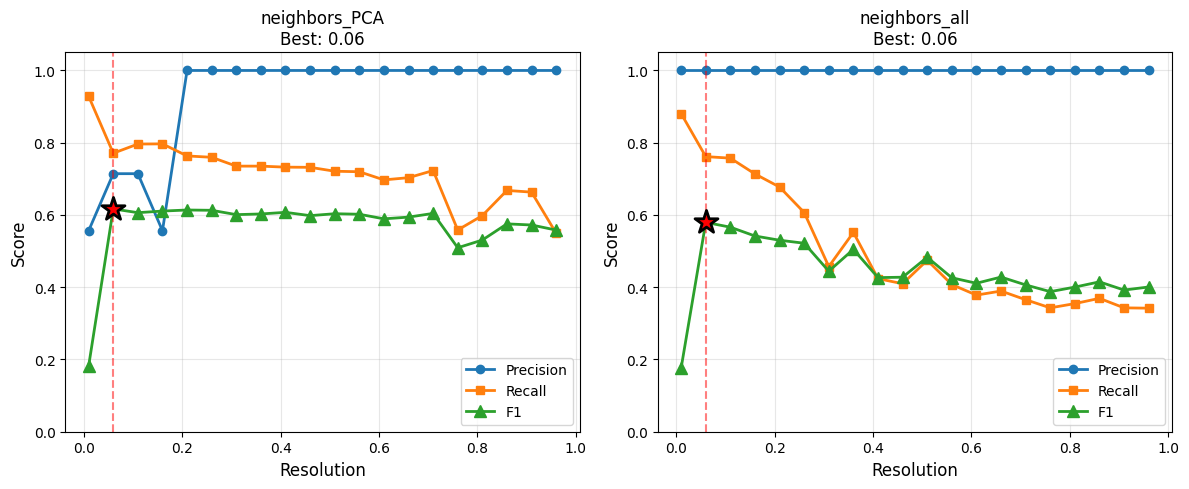


Summary:

neighbors_PCA:
  Best resolution: 0.060000000000000005
  Best cluster: 1
  F1 Score: 0.617
  Leiden key: leiden_PCA_0.06

neighbors_all:
  Best resolution: 0.060000000000000005
  Best cluster: 5
  F1 Score: 0.579
  Leiden key: leiden_all_0.06

Use these keys for best clustering:
  PCA: leiden_PCA_0.06
  All: leiden_all_0.06


In [ ]:
def find_best_leiden_resolution(
    adata,
    true_secreted,
    neighbors_keys=["neighbors_pca", "neighbors_all"],
    resolution_range=None,
    metric='f1',
    n_iterations=2,
    flavor="igraph",
    plot=True
):
    """
    Find optimal Leiden clustering resolution to maximize overlap with known secreted proteins.
    The putative secreted protein cluster is the one with max overlap.
    """
    from tqdm import tqdm
    
    if resolution_range is None:
        resolution_range = np.arange(0.1, 2.1, 0.1)
    
    set_secreted = set(true_secreted)
    results = {}
    
    for neighbors_key in neighbors_keys:
        print(f"\nTesting {neighbors_key}")
        all_results = []
        
        # Progress bar for resolutions
        for resolution in tqdm(resolution_range, desc=f"{neighbors_key}"):
            key_added = f"leiden_{neighbors_key.replace('neighbors_', '')}_{resolution:.2f}"
            
            sc.tl.leiden(
                adata,
                resolution=resolution,
                neighbors_key=neighbors_key,
                key_added=key_added,
                flavor=flavor,
                n_iterations=n_iterations
            )
            
            # Test each cluster
            for cluster in adata.obs[key_added].unique():
                set_putative = set(adata.obs[adata.obs[key_added] == cluster].index)
                overlap = len(set_putative.intersection(set_secreted))
                
                precision = overlap / len(set_putative) if len(set_putative) > 0 else 0
                recall = overlap / len(set_secreted) if len(set_secreted) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                all_results.append({
                    'resolution': resolution,
                    'cluster': cluster,
                    'overlap': overlap,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'key_added': key_added
                })
        
        df = pd.DataFrame(all_results)
        best_row = df.loc[df[metric].idxmax()]
        
        results[neighbors_key] = {
            'best_resolution': best_row['resolution'],
            'best_cluster': best_row['cluster'],
            'best_f1': best_row['f1'],
            'best_precision': best_row['precision'],
            'best_recall': best_row['recall'],
            'best_key': best_row['key_added'],
            'all_results': df
        }
        
        print(f"Best: Res={best_row['resolution']:.2f}, Cluster={best_row['cluster']}, "
              f"F1={best_row['f1']:.3f}, P={best_row['precision']:.3f}, R={best_row['recall']:.3f}")
    
    # Simple plot
    if plot:
        fig, axes = plt.subplots(1, len(neighbors_keys), figsize=(6*len(neighbors_keys), 5))
        if len(neighbors_keys) == 1:
            axes = [axes]
        
        for i, neighbors_key in enumerate(neighbors_keys):
            df = results[neighbors_key]['all_results']
            best_per_res = df.groupby('resolution')[['precision', 'recall', 'f1']].max()
            
            axes[i].plot(best_per_res.index, best_per_res['precision'], 'o-', label='Precision', linewidth=2)
            axes[i].plot(best_per_res.index, best_per_res['recall'], 's-', label='Recall', linewidth=2)
            axes[i].plot(best_per_res.index, best_per_res['f1'], '^-', label='F1', linewidth=2, markersize=8)
            
            best_res = results[neighbors_key]['best_resolution']
            best_score = results[neighbors_key][f'best_{metric}']
            axes[i].axvline(best_res, color='red', linestyle='--', alpha=0.5)
            axes[i].scatter([best_res], [best_score], color='red', s=300, marker='*', 
                          zorder=5, edgecolors='black', linewidth=2)
            
            axes[i].set_xlabel('Resolution', fontsize=12)
            axes[i].set_ylabel('Score', fontsize=12)
            axes[i].set_title(f'{neighbors_key}\nBest: {best_res:.2f}', fontsize=12)
            axes[i].legend(fontsize=10)
            axes[i].grid(True, alpha=0.3)
            axes[i].set_ylim(0, 1.05)
        
        plt.tight_layout()
        plt.show()
    
    return results


# Usage example:
results = find_best_leiden_resolution(
    adata,
    true_secreted=protein_secreted,  # Your list of true secreted proteins
    neighbors_keys=["neighbors_pca", "neighbors_all"],
    resolution_range=np.arange(0.01, 1, 0.05),
    metric='f1',  # or 'precision', 'recall', 'jaccard'
    plot=True
)

# Access best results
print("\nSummary:")
for key, res in results.items():
    print(f"\n{key}:")
    print(f"  Best resolution: {res['best_resolution']}")
    print(f"  Best cluster: {res['best_cluster']}")
    print(f"  F1 Score: {res['best_f1']:.3f}")
    print(f"  Leiden key: {res['best_key']}")

# Apply best clustering
best_pca_key = results['neighbors_pca']['best_key']
best_all_key = results['neighbors_all']['best_key']

# These are already in adata.obs, you can use them directly
print(f"\nUse these keys for best clustering:")
print(f"  PCA: {best_pca_key}")
print(f"  All: {best_all_key}")

Plotting 1/4: basis=X_umap_PCA, color=secreted, size=5, groups=None, legend_loc=None
Plotting 2/4: basis=X_umap_all, color=secreted, size=5, groups=None, legend_loc=None
Plotting 3/4: basis=X_umap_PCA, color=leiden_PCA_0.06, size=5, groups=['1'], legend_loc=None


Plotting 4/4: basis=X_umap_all, color=leiden_all_0.06, size=5, groups=['5'], legend_loc=None


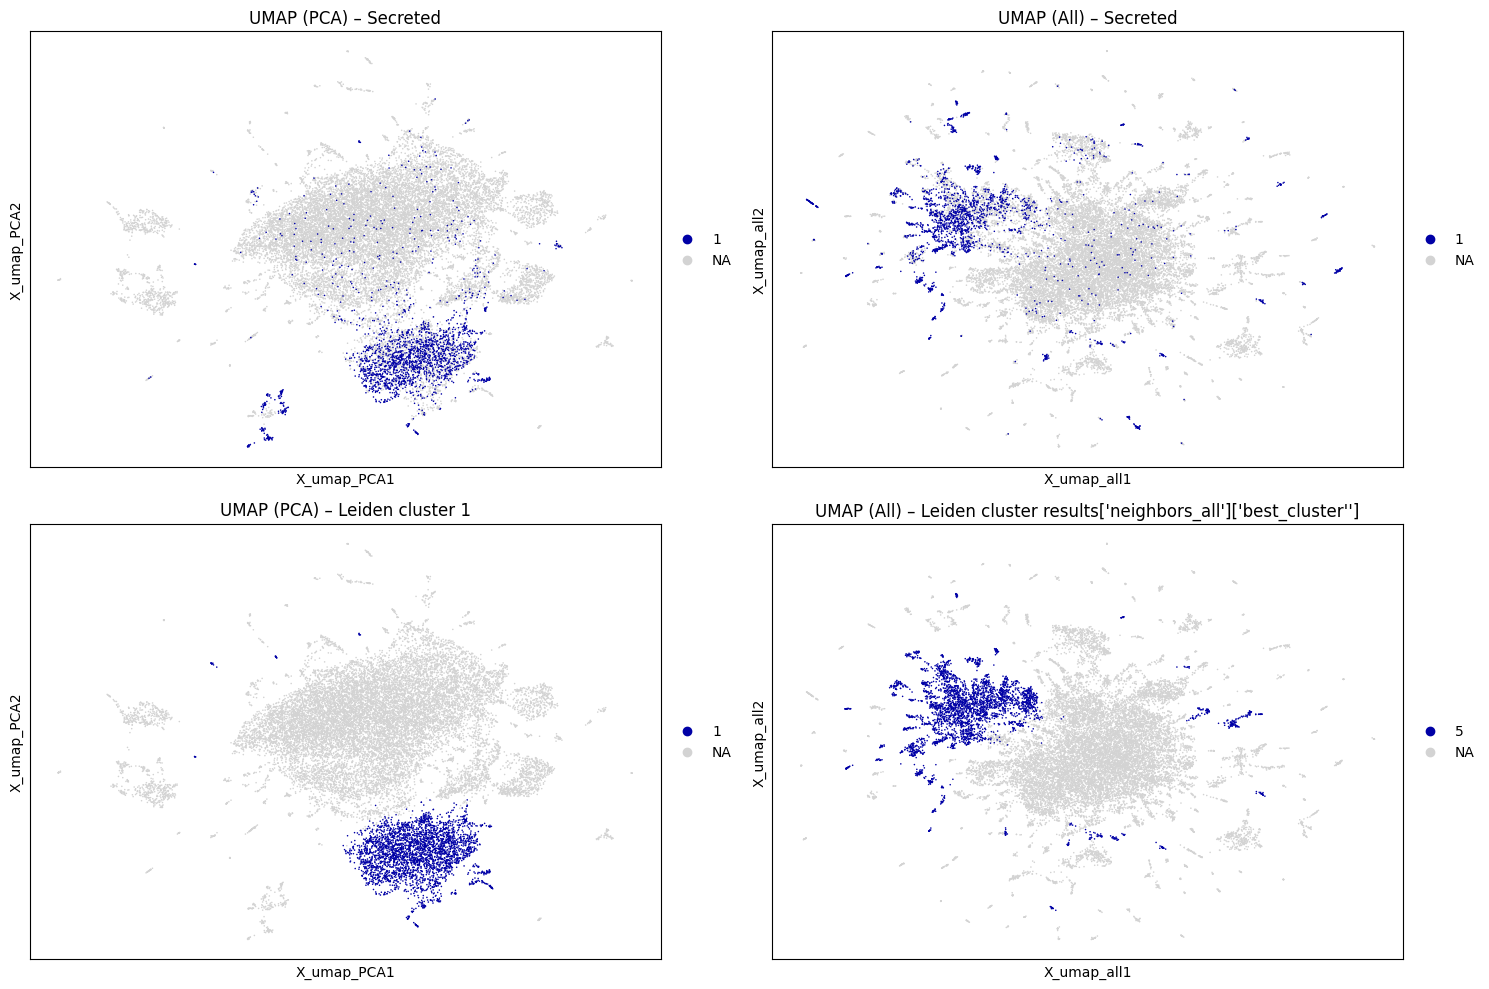

In [ ]:
fig, axes = my_embs.plot_embeddings(
    adata,
    basis=["X_umap_pca", "X_umap_all", "X_umap_pca", "X_umap_all"],
    color=["secreted", "secreted", results["neighbors_pca"]["best_key"], results["neighbors_all"]["best_key"]],
    groups=[None, None, [results["neighbors_pca"]["best_cluster"]], [results["neighbors_all"]["best_cluster"]]],
    title=[
        "UMAP (PCA) – Secreted",
        "UMAP (All) – Secreted",
        f"UMAP (PCA) – Leiden cluster {results['neighbors_pca']['best_cluster']}",
        f"UMAP (All) – Leiden cluster results['neighbors_all']['best_cluster']"
    ],
    size=[5],
    palette=[["#0000A6"]],
    ncols=2,  # 2 columns, 2 rows
    figsize=(15, 10)
)
plt.show()

In [ ]:
set_secreted = set(protein_secreted)
set_putative = set(adata.obs[adata.obs[results["neighbors_pca"]["best_key"]] ==  results["neighbors_pca"]["best_cluster"]].index)

overlap_count = len(set_putative.intersection(set_secreted))
total_putative = len(set_putative)
total_secreted = len(set_secreted)

# Calculate metrics
precision = overlap_count / total_putative if total_putative > 0 else 0
recall = overlap_count / total_secreted if total_secreted > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Jaccard index (intersection over union)
union_count = len(set_putative.union(set_secreted))
jaccard = overlap_count / union_count if union_count > 0 else 0

# Overlap percentage (same as recall)
overlap_percentage = recall * 100

print(f"Overlap Count: {overlap_count}")
print(f"Putative Secreted: {total_putative}")
print(f"Known Secreted: {total_secreted}")
print(f"\nPrecision: {precision:.2%} ({overlap_count}/{total_putative})")
print(f"  → Of putative secreted proteins, what % are truly secreted?")
print(f"\nRecall: {recall:.2%} ({overlap_count}/{total_secreted})")
print(f"  → Of all known secreted proteins, what % did you capture?")
print(f"\nF1-Score: {f1_score:.2%}")
print(f"  → Harmonic mean of precision and recall")
print(f"\nJaccard Index: {jaccard:.2%} ({overlap_count}/{union_count})")
print(f"  → Overlap relative to total unique proteins in both sets")
print(f"\nOverlap Percentage: {overlap_percentage:.2f}%")
print(f"  → Same as recall: {overlap_count}/{total_secreted} known secreted proteins captured")

Overlap Count: 1639
Putative Secreted: 3189
Known Secreted: 2126

Precision: 51.40% (1639/3189)
  → Of putative secreted proteins, what % are truly secreted?

Recall: 77.09% (1639/2126)
  → Of all known secreted proteins, what % did you capture?

F1-Score: 61.67%
  → Harmonic mean of precision and recall

Jaccard Index: 44.59% (1639/3676)
  → Overlap relative to total unique proteins in both sets

Overlap Percentage: 77.09%
  → Same as recall: 1639/2126 known secreted proteins captured


# Search Reactome Processes that maps to specific cluster

In [5]:
df_genesets = dataf.load_json_folder_to_df("/home/gdallagl/myworkdir/ESMSec/data/MSigDB/msigdb_v2025.1.Hs_json_files_to_download_locally")
df_genesets = df_genesets.drop_duplicates(subset=['set_name'], keep='first')

# Select on reactome 
print(df_genesets.collection.unique())
DB_to_use = ["H", "C6", "C5", "C2:CP:REACTOME"]
df_genesets = df_genesets[df_genesets["collection"].isin(DB_to_use)]

display(df_genesets.head(2)); print(df_genesets.shape)

['C3:MIR:MIRDB' 'C7:IMMUNESIGDB' 'C3:TFT:GTRD' 'C5:GO:CC' 'C7:VAX' 'C4:CM'
 'C3:MIR:MIR_LEGACY' 'H' 'C2:CP:KEGG_MEDICUS' 'C5:GO:BP' 'C5:GO:MF'
 'C3:TFT:TFT_LEGACY' 'C2:CGP' 'C2:CP:BIOCARTA' 'C2:CP:KEGG_LEGACY'
 'C2:CP:PID' 'C2:CP:REACTOME' 'C2:CP:WIKIPATHWAYS' 'C2:CP' 'C1' 'C8'
 'C4:CGN' 'C6' 'C4:3CA' 'C5:HPO']


,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file
12172,HALLMARK_TNFA_SIGNALING_VIA_NFKB,H,M5890,26771021,,,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ABCA1, ACKR3, AREG, ATF3, ATP2B1, B4GALT1, B4...",[],[],h.all.v2025.1.Hs.json
12173,HALLMARK_HYPOXIA,H,M5891,26771021,,,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ACKR3, ADM, ADORA2B, AK4, AKAP12, ALDOA, ALDO...",[],[],h.all.v2025.1.Hs.json


(2026, 11)


In [17]:
# Add proteins name to df_geneset
df_genesets["proteins"] = df_genesets.geneSymbols.apply(
    lambda genes: [gene_to_protein.get(g, None) for g in genes]
)
df_genesets["n_proteins"] = df_genesets.proteins.apply(len)
df_genesets["n_genes"] = df_genesets.geneSymbols.apply(len)

# check if some gens are lost in transaltion
df_genesets[df_genesets.n_proteins != df_genesets.n_genes]

# ATTNETION: only study geneset with more thna ... proteins
df_genesets = df_genesets[df_genesets.n_proteins >= 30]

display(df_genesets.head(2)); print(df_genesets.shape)

,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file,proteins,n_proteins,n_genes,protein_indices,silhouette
35460,REACTOME_RHO_GTPASES_ACTIVATE_IQGAPS,C2:CP:REACTOME,M27491,,R-HSA-5626467,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ACTB, ACTG1, CALM1, CDC42, CDH1, CLIP1, CTNNA...",[],[],c2.all.v2025.1.Hs.json,"[G5E9R0, K7EM38, G3V479, Q5JYX0, J3QKP1, J3KP5...",32,32,"[2483, 2484, 100, 12166, 6057, 11508, 5123, 121]",0.812403
35549,REACTOME_METALLOPROTEASE_DUBS,C2:CP:REACTOME,M27580,,R-HSA-5689901,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ABRAXAS1, ABRAXAS2, BABAM1, BABAM2, BARD1, BR...",[],[],c2.all.v2025.1.Hs.json,"[E9PHB9, Q15018, M0R3H9, F8W733, F8WCG2, Q3B89...",37,37,"[6339, 10963, 2419, 10705, 2419, 11216, 2419, ...",0.767904


(983, 16)


In [18]:
# Calcurte cohesion for each geneset in PCA space

from scipy.spatial.distance import cdist

# Map protein IDs to indices
protein_to_idx = {p: i for i, p in enumerate(adata.obs_names)}
X_pca = adata.obsm["X_pca"]

def proteins_to_indices(protein_list):
    return [protein_to_idx[p] for p in protein_list if p in protein_to_idx]

def silhouette_score_cluster(indices, X):
    """Best metric: Range [-1, 1], higher = better separated and cohesive"""
    if len(indices) < 2:
        return np.nan
    
    X_cluster = X[indices]
    rest_indices = list(set(range(len(X))) - set(indices))
    X_rest = X[rest_indices]
    
    scores = []
    for i in range(len(X_cluster)):
        a = np.mean(cdist([X_cluster[i]], np.delete(X_cluster, i, axis=0))[0])
        b = np.mean(cdist([X_cluster[i]], X_rest)[0]) if len(X_rest) > 0 else 0
        scores.append((b - a) / max(a, b) if max(a, b) > 0 else 0)
    
    return np.mean(scores)

# Compute and save to df_genesets
df_genesets["protein_indices"] = df_genesets.proteins.apply(proteins_to_indices)
df_genesets = df_genesets[df_genesets.protein_indices.apply(len) >= 2].copy()

print("Computing silhouette scores...")
df_genesets["silhouette"] = [
    silhouette_score_cluster(idx, X_pca) 
    for idx in tqdm(df_genesets.protein_indices)
]

# View top results
display(df_genesets[["set_name", "silhouette"]].head(10))

Computing silhouette scores...


  0%|          | 0/983 [00:00<?, ?it/s]

100%|██████████| 983/983 [00:23<00:00, 42.36it/s]


,set_name,silhouette
35460,REACTOME_RHO_GTPASES_ACTIVATE_IQGAPS,0.812403
35549,REACTOME_METALLOPROTEASE_DUBS,0.767904
35088,REACTOME_HDMS_DEMETHYLATE_HISTONES,0.737545
35715,REACTOME_BASE_EXCISION_REPAIR_AP_SITE_FORMATION,0.692701
39702,REACTOME_RECOGNITION_AND_ASSOCIATION_OF_DNA_GL...,0.692701
35799,REACTOME_E3_UBIQUITIN_LIGASES_UBIQUITINATE_TAR...,0.691524
35620,REACTOME_REGULATION_OF_TP53_EXPRESSION_AND_DEG...,0.677295
35556,REACTOME_NONHOMOLOGOUS_END_JOINING_NHEJ,0.673125
35090,REACTOME_RMTS_METHYLATE_HISTONE_ARGININES,0.670446
35166,REACTOME_OLFACTORY_SIGNALING_PATHWAY,0.667519


In [19]:
# Sort by best compactness
df_genesets = df_genesets.sort_values(["silhouette", "n_proteins"], ascending=False)
df_genesets

,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file,proteins,n_proteins,n_genes,protein_indices,silhouette
35460,REACTOME_RHO_GTPASES_ACTIVATE_IQGAPS,C2:CP:REACTOME,M27491,,R-HSA-5626467,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ACTB, ACTG1, CALM1, CDC42, CDH1, CLIP1, CTNNA...",[],[],c2.all.v2025.1.Hs.json,"[G5E9R0, K7EM38, G3V479, Q5JYX0, J3QKP1, J3KP5...",32,32,"[2483, 2484, 100, 12166, 6057, 11508, 5123, 121]",0.812403
35549,REACTOME_METALLOPROTEASE_DUBS,C2:CP:REACTOME,M27580,,R-HSA-5689901,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ABRAXAS1, ABRAXAS2, BABAM1, BABAM2, BARD1, BR...",[],[],c2.all.v2025.1.Hs.json,"[E9PHB9, Q15018, M0R3H9, F8W733, F8WCG2, Q3B89...",37,37,"[6339, 10963, 2419, 10705, 2419, 11216, 2419, ...",0.767904
35088,REACTOME_HDMS_DEMETHYLATE_HISTONES,C2:CP:REACTOME,M27232,,R-HSA-3214842,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ARID5B, H3C1, H3C10, H3C11, H3C12, H3C13, H3C...",[],[],c2.all.v2025.1.Hs.json,"[A0A7P0TAD2, P68431, P68431, P68431, P68431, Q...",50,50,"[5126, 5126, 5126, 5126, 8010, 8010, 8010, 512...",0.737545
35715,REACTOME_BASE_EXCISION_REPAIR_AP_SITE_FORMATION,C2:CP:REACTOME,M27700,,R-HSA-73929,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ACD, H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H...",[],[],c2.all.v2025.1.Hs.json,"[R4GND4, P0C5Y9, Q99878, Q6FI13, Q6FI13, Q1677...",62,62,"[2424, 11216, 7479, 7479, 6690, 2086, 10156, 3...",0.692701
39702,REACTOME_RECOGNITION_AND_ASSOCIATION_OF_DNA_GL...,C2:CP:REACTOME,M29526,,R-HSA-110330,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ACD, H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H...",[],[],c2.all.v2025.1.Hs.json,"[R4GND4, P0C5Y9, Q99878, Q6FI13, Q6FI13, Q1677...",55,55,"[2424, 11216, 7479, 7479, 6690, 2086, 10156, 3...",0.692701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35562,REACTOME_FORMATION_OF_INCISION_COMPLEX_IN_GG_NER,C2:CP:REACTOME,M1005,,R-HSA-5696395,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[CCNH, CDK7, CETN2, CHD1L, CUL4A, CUL4B, DDB1,...",[],[],c2.all.v2025.1.Hs.json,"[A0A2R8Y4K6, D6RI01, P41208, A0A494C1S1, A0A08...",43,43,"[3963, 5066]",-0.089435
51878,BCAT_BILD_ET_AL_UP,C6,M2703,16273092,activated CTNNB1 vs GFP; top 50 genes (mutual ...,,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ACTN4, AXIN2, B4GALT1, BMP4, C4orf36, CALR, C...",[],[],msigdb.v2025.1.Hs.json,"[K7EP19, J3QRK4, A0ABB0MVD1, V9GYF1, Q96KX1, K...",45,45,"[20354, 1613, 5595, 11843, 16193, 3323, 5138, ...",-0.109712
36307,REACTOME_ATP_DEPENDENT_CHROMATIN_REMODELERS,C2:CP:REACTOME,M49182,,R-HSA-9932444,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ACTB, ACTL6A, ACTL6B, ARID1A, ARID1B, ARID2, ...",[],[],c2.all.v2025.1.Hs.json,"[G5E9R0, H7C5S0, C9JQT4, H0YEW5, H0Y3S9, F8VWP...",31,31,"[6939, 7446]",-0.112567
36278,REACTOME_TURBULENT_OSCILLATORY_DISTURBED_FLOW_...,C2:CP:REACTOME,M49158,,R-HSA-9860927,https://www.reactome.org/content/detail/R-HSA-...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[ABL1, ANXA2, CAPN2, CAPNS1, CAPNS2, CHUK, FN1...",[],[],c2.all.v2025.1.Hs.json,"[R4GRW0, H0YNP5, C9JWY7, U3KQE2, Q96L46, O1511...",31,31,"[10728, 547]",-0.175726


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from PIL import Image
import io

print("Generating plots directly to memory...")
images = []

for i, row in tqdm(df_genesets.iterrows(), total=len(df_genesets), desc="Plotting genesets"):
    
    adata.obs["highlight"] = [1 if p in row.proteins else None for p in adata.obs_names]
    adata.obs['highlight'] = pd.Categorical(adata.obs['highlight'], categories=[1], ordered=True)
    
    title = f"{row.get('set_name', row.name)} (Cohesion={row.silhouette:.3f})"
    
    fig, axes = my_embs.plot_embeddings(
        adata,
        basis=["X_umap_pca", "X_umap_all"],
        color=["highlight", "highlight"],
        title=[f"{title} (pca)", f"{title} (All)"],
        size=[15],
        palette=[["#BA0900"]],
        ncols=2,
        figsize=(16, 8),
    )
    
    # Save directly to memory buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf).convert('RGB')
    images.append(img)
    plt.close(fig)

print(f"\nSaving {len(images)} plots to PDF...")
images[0].save(
    "umap_genesets.pdf",
    save_all=True,
    append_images=images[1:],
    resolution=100.0,
    quality=85
)
print("Done!")

Generating plots directly to memory...


Plotting genesets:   0%|          | 0/983 [00:00<?, ?it/s]

Plotting genesets: 100%|██████████| 983/983 [16:36<00:00,  1.01s/it]



Saving 983 plots to PDF...
Done!


# Cell Locations from from CD-CODE

In [98]:
df_location = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniProt/protein_in_condensates_CD-CODE.tsv", sep="\t")

# filter only protein in adata
df_location = df_location.loc[df_location["uniprotkb_ac"].isin(adata.obs.index)]

# # ATTNETION: # Drop proteins in MULTIPLE locations
# df_location = df_location.drop_duplicates(subset=["uniprotkb_ac"], keep=False)
# display(df_location[df_location.duplicated(subset=["uniprotkb_ac"], keep=False)].sort_values(by="uniprotkb_ac")) # check for duoslaictes

display(df_location.condensate_name.value_counts())
allowed_condensates = df_location.condensate_name.value_counts()[df_location.condensate_name.value_counts() >= 10].index.to_list()
print(len(allowed_condensates), allowed_condensates)

condensate_name
Nucleolus                                          1401
Presynaptic clusters and postsynaptic densities    1363
Stress granule                                      852
Centrosome                                          539
P-body                                              495
                                                   ... 
eukaryotic topoisomerase ii                           1
DVL2 condensates                                      1
TIS granule                                           1
Galectin complex                                      1
Granular component                                    1
Name: count, Length: 327, dtype: int64

21 ['Nucleolus', 'Presynaptic clusters and postsynaptic densities', 'Stress granule', 'Centrosome', 'P-body', 'Nuclear speckle', 'PML body', 'Cajal body', 'Paraspeckle', 'mtRNA granule', 'IMP1 RNP granule', 'Transcriptional condensate', 'Nuclear pore complex', 'Signaling cluster', 'Leucocyte nuclear body', 'DNA damage foci', 'Neuronal RNP granule', 'Sam68 nuclear body', 'PcG body', 'Nuclear stress body', 'Synthetic Condensate 000375']


In [99]:
for loc in allowed_condensates:
    # select proteisn in datset
    prot_in_loc = df_location[df_location.condensate_name == loc].uniprotkb_ac.to_list()
    #print(loc, prot_in_loc)
    # Mark proteins
    adata.obs[f"loc_{loc}"] = [1 if p in prot_in_loc else None for p in adata.obs.index]
    adata.obs[f"loc_{loc}"] = pd.Categorical(
        adata.obs[f"loc_{loc}"],
        categories=[1],  # 0 plotted first (bottom), 1 on top
        ordered=True
    )

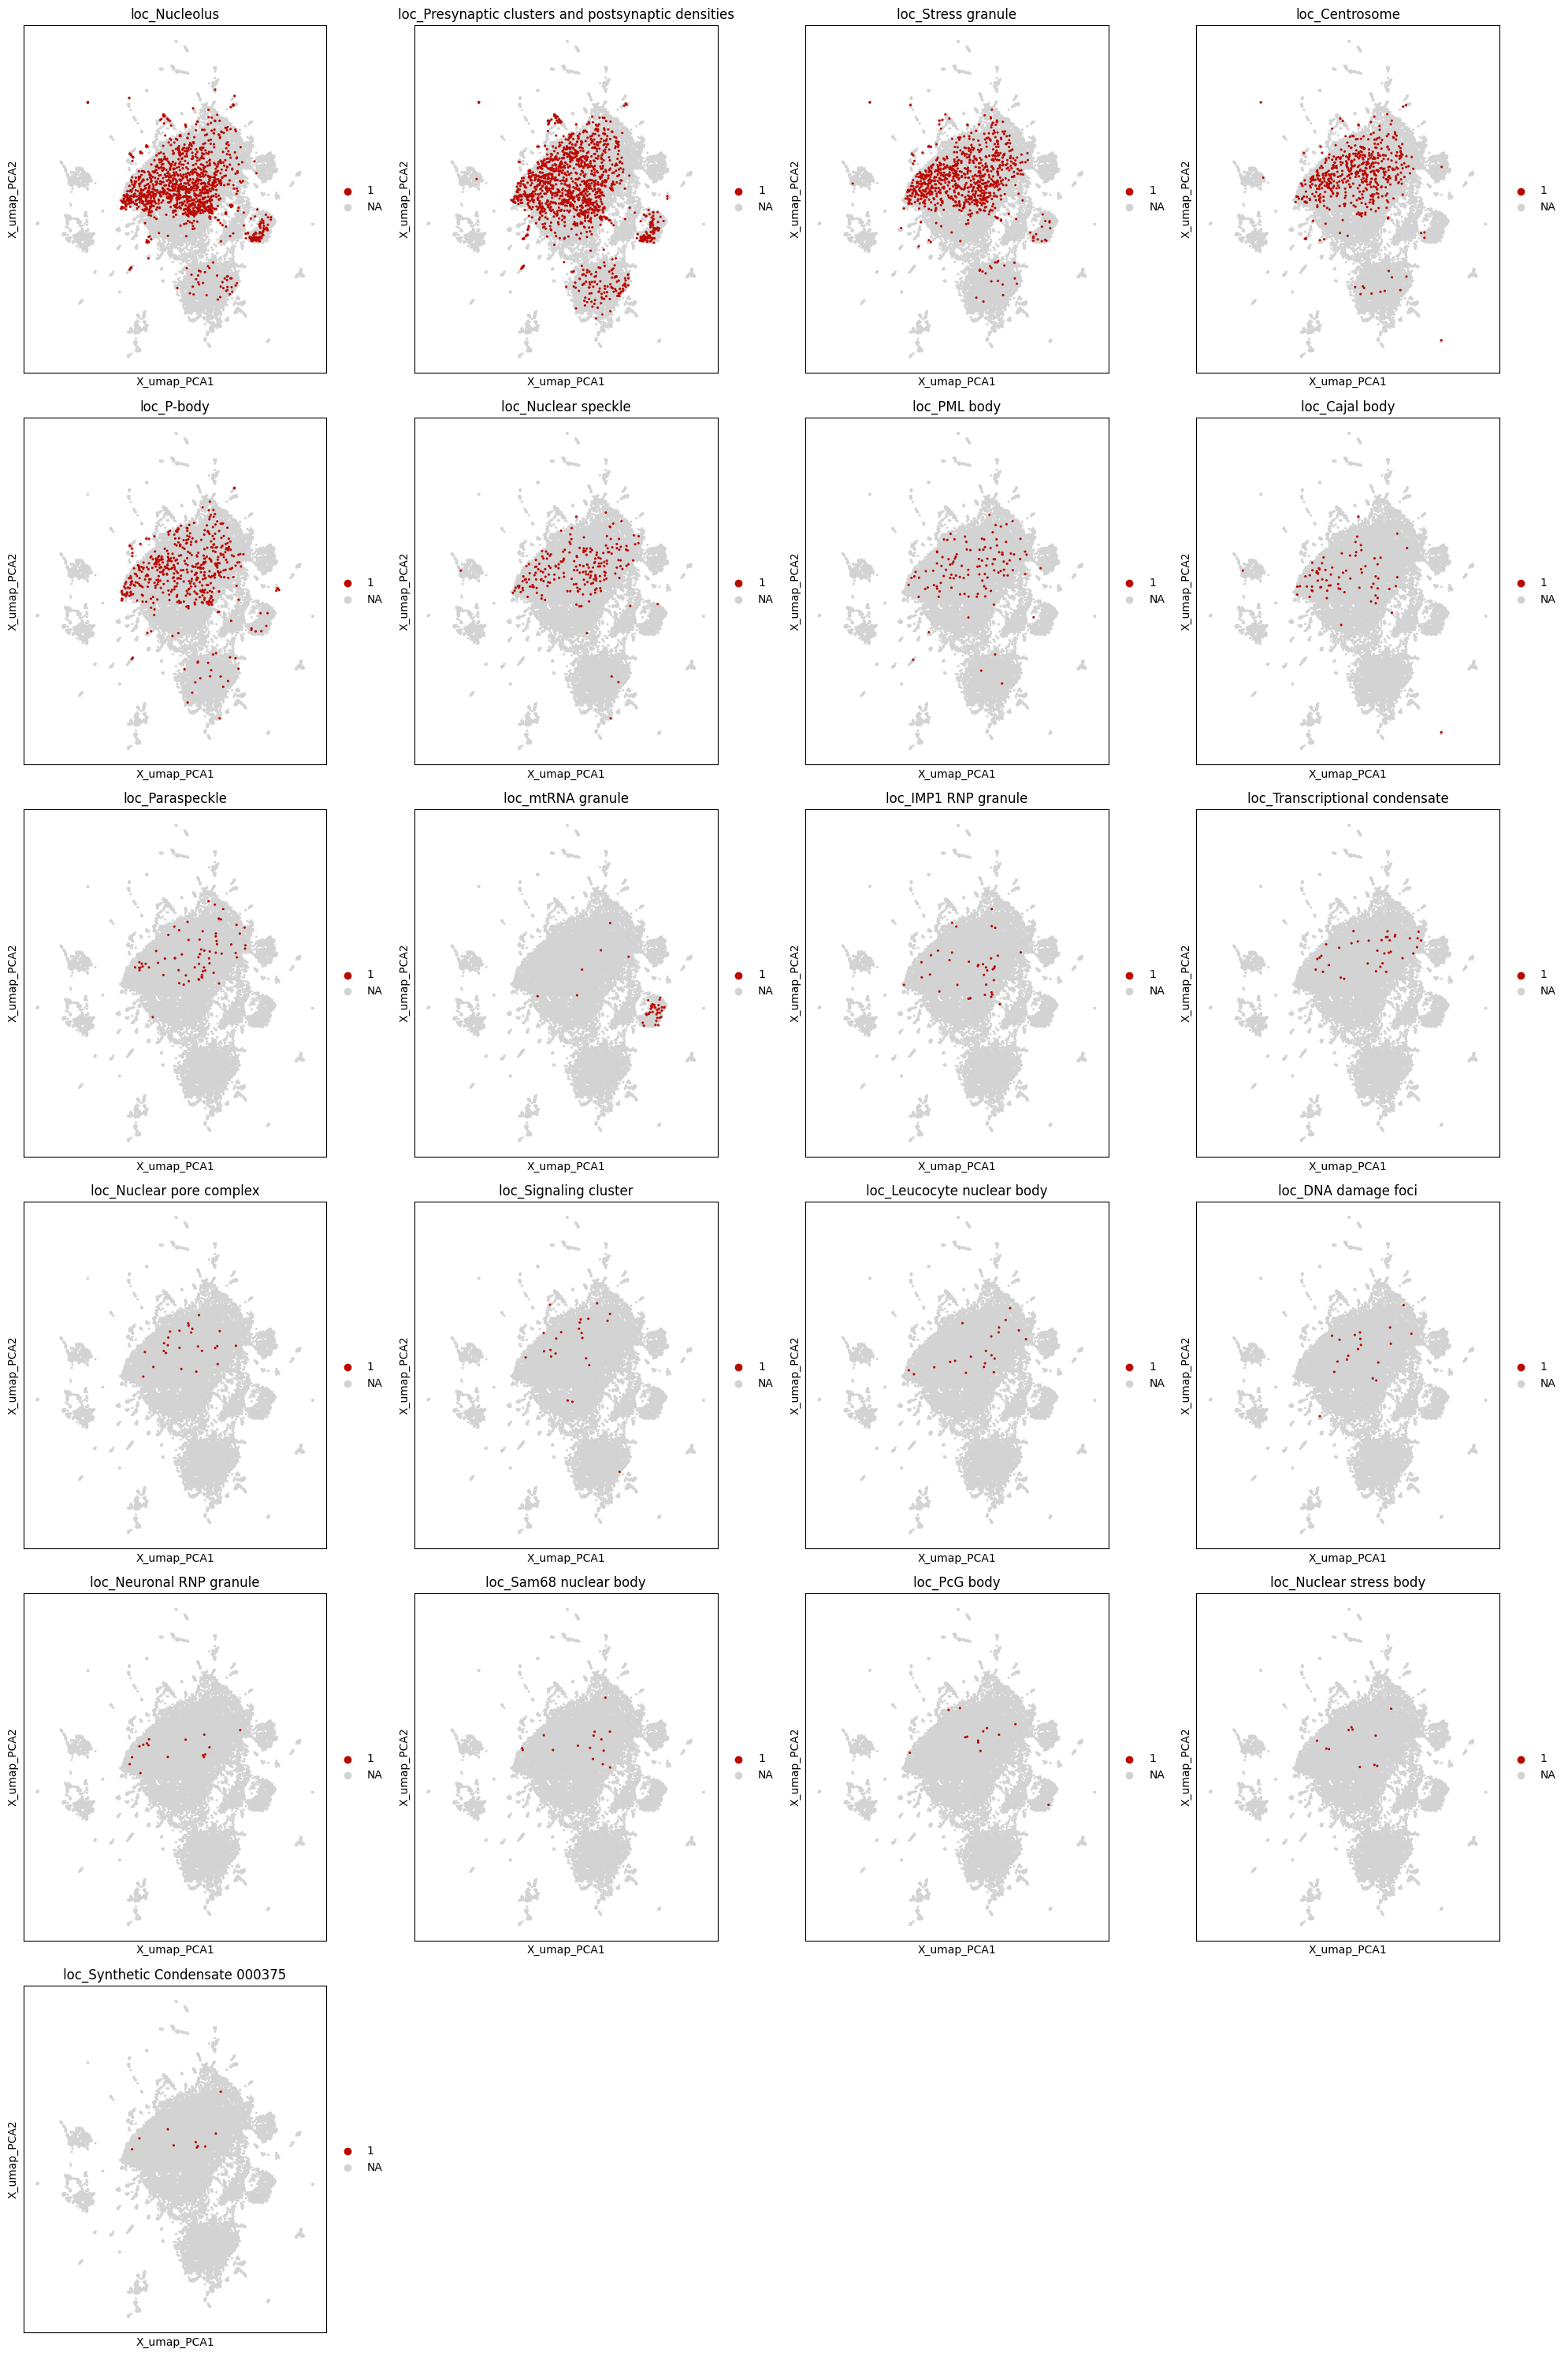

In [ ]:
fig, axes = my_embs.plot_embeddings(
    adata,
    basis=["X_umap_pca"]*len([col for col in adata.obs.columns if "loc" in col]),
    color=[col for col in adata.obs.columns if "loc" in col],
    title=[col for col in adata.obs.columns if "loc" in col],
    size=[20],
    palette=[["#BA0900"]],
    ncols=4,
    figsize=(20, 30),
)